In [10]:
# full_evaluation_pipeline.py

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score
)
from sklearn.calibration import calibration_curve
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MultiLabelBinarizer

# ========== Dataset Class ==========
class JobSkillDataset(Dataset):
    def __init__(self, summaries, labels, tokenizer, max_len):
        self.summaries = summaries
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.summaries)

    def __getitem__(self, item):
        summary = str(self.summaries[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            summary,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.float)
        }

# ========== Token Overlap Function ==========
def token_overlap_score(y_true, y_pred, mlb_classes):
    scores = []
    for true_row, pred_row in zip(y_true, y_pred):
        true_skills = [mlb_classes[i] for i in np.where(true_row == 1)[0]]
        pred_skills = [mlb_classes[i] for i in np.where(pred_row == 1)[0]]
        overlap = []
        for t in true_skills:
            for p in pred_skills:
                tokens_t = set(re.findall(r'\w+', t.lower()))
                tokens_p = set(re.findall(r'\w+', p.lower()))
                if tokens_t or tokens_p:
                    overlap.append(len(tokens_t & tokens_p) / len(tokens_t | tokens_p))
        if overlap:
            scores.append(np.mean(overlap))
    return np.mean(scores) if scores else 0.0

# ========== Evaluation Function for Notebook ==========
def evaluate_model_locally(df, model_path, threshold=0.3):
    df = df[['job_skills', 'job_summary']]
    df['job_skills'] = df['job_skills'].apply(lambda x: str(x).split(',') if isinstance(x, str) else [])

    mlb = MultiLabelBinarizer()
    y = mlb.fit_transform(df['job_skills'])

    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    dataset = JobSkillDataset(df['job_summary'].tolist(), y, tokenizer, max_len=256)
    dataloader = DataLoader(dataset, batch_size=16)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = DistilBertForSequenceClassification.from_pretrained(model_path, num_labels=y.shape[1])
    model.to(device)
    model.eval()

    all_probs = []
    all_labels = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            probs = torch.sigmoid(outputs.logits).cpu().numpy()
            all_probs.extend(probs)
            all_labels.extend(labels.cpu().numpy())

    y_prob = np.array(all_probs)
    y_val = np.array(all_labels)
    y_pred = (y_prob > threshold).astype(int)

    metrics = {
        "Precision (micro)": precision_score(y_val, y_pred, average='micro'),
        "Recall (micro)": recall_score(y_val, y_pred, average='micro'),
        "F1 Score (micro)": f1_score(y_val, y_pred, average='micro'),
        "Precision (macro)": precision_score(y_val, y_pred, average='macro'),
        "Recall (macro)": recall_score(y_val, y_pred, average='macro'),
        "F1 Score (macro)": f1_score(y_val, y_pred, average='macro'),
        "Exact Match Accuracy": np.mean(np.all(y_val == y_pred, axis=1))
    }

    try:
        metrics["AUC-ROC (macro)"] = roc_auc_score(y_val, y_prob, average='macro')
    except ValueError:
        metrics["AUC-ROC (macro)"] = None

    metrics["Token Overlap"] = token_overlap_score(y_val, y_pred, mlb.classes_)

    print("\n--- Evaluation Results ---")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}" if value is not None else f"{key}: N/A")

    pd.DataFrame([metrics]).to_csv("evaluation_metrics.csv", index=False)
    print("Saved metrics to 'evaluation_metrics.csv'")

    print("\n--- Calibration Curve ---")
    prob_true, prob_pred = calibration_curve(y_val.ravel(), y_prob.ravel(), n_bins=10)
    plt.figure(figsize=(6, 6))
    plt.plot(prob_pred, prob_true, marker='o', label='Model')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
    plt.xlabel('Mean Predicted Probability')
    plt.ylabel('Fraction of Positives')
    plt.title('Calibration Curve')
    plt.legend()
    plt.grid(True)
    plt.savefig("calibration_curve.png")
    print("Saved calibration curve to 'calibration_curve.png'")


/opt/homebrew/Cellar/jupyterlab/4.4.1/libexec/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/opt/homebrew/Cellar/jupyterlab/4.4.1/libexec/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



--- Evaluation Results ---
Precision (micro): 0.5051
Recall (micro): 0.1198
F1 Score (micro): 0.1937
Precision (macro): 0.0853
Recall (macro): 0.0439
F1 Score (macro): 0.0504
Exact Match Accuracy: 0.0141
AUC-ROC (macro): 0.8174
Token Overlap: 0.1610
Saved metrics to 'evaluation_metrics.csv'

--- Calibration Curve ---
Saved calibration curve to 'calibration_curve.png'


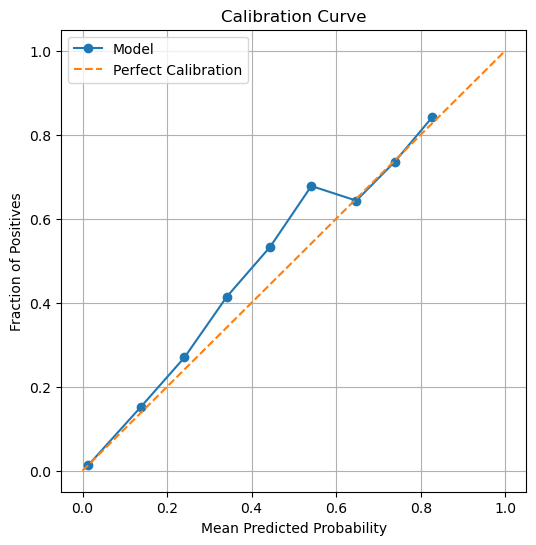

In [12]:
# 🔧 Install required libraries
!pip install --quiet pandas scikit-learn matplotlib transformers torch

# 🧪 Re-run this AFTER installation to evaluate
import pandas as pd

# Load your dataset
df = pd.read_csv("10K_top100skills.csv")

# Evaluate the model (this function is defined in your notebook as `evaluate_model_locally`)
evaluate_model_locally(df, model_path="./myModel", threshold=0.3)
